# <color style="color:red">**!! Disclaimer !!**</color>
This exercise serves as a comprehensive guide on the following topics:
* How to convert a Keras model to a TensorFlow Lite model
* How to deploy a TensorFlow Lite model on an MCU and run inference
* How to optimize a TensorFlow Lite model for size and latency

It is very much likely that you will not be able to finish the entire exercise in the time given for the lab. **Student Task 1** to **Student Task 8** will likely require assistance from the lab instructors. The other tasks follow the same principle and can be done autonomously.

### <color style="color:green">**Contributions and License**</color>
This notebook is licensed under the [Apache License 2.0](https://www.apache.org/licenses/LICENSE-2.0).
We thank the following contributors for their contributions to this notebook:
* Viviane Potocnik <vivianep@iis.ee.ethz.ch> (ETH Zurich)
* TensorFlow team [https://www.tensorflow.org/](https://www.tensorflow.org/)
* Moritz Scherer <scheremo@iis.ee.ethz.ch> (ETH Zurich)

# Setup
Firstly, we load all the necessary packages used in this notebook and define some settings for visualizing the input image data. If you encounter `ModuleNotFoundError`, please install the corresponding package using `pip install` or `conda install`.

In [30]:
# Copyright 2021 ETH Zurich and University of Bologna.
# Licensed under the Apache License, Version 2.0, see https://www.apache.org/licenses/LICENSE-2.0 for details.
# SPDX-License-Identifier: Apache-2.0

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models
import seaborn as sn
import os
import logging
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import pathlib

# set global seeds for reproducibility
tf.random.set_seed(1234)
np.random.seed(1234)

# Setting parameters for plotting
plt.rcParams['figure.figsize'] = (15.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

logging.getLogger("tensorflow").setLevel(logging.DEBUG)

print("TensorFlow version: ", tf.__version__)

TensorFlow version:  2.11.0


In [31]:
# check if GPU is available
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

GPU is NOT AVAILABLE


# Task 1

### Download the dataset
For this we use the keras.datasets.mnist package. This package contains the Fashion-MNIST dataset which is a dataset of 60,000 28x28 grayscale images of 10 fashion categories, along with a test set of 10,000 images. This dataset can be used as a drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

In [32]:
# Load Fashion-Mnist dataset, we can use Tensorflow for this
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# we save the pixels before normalization for plotting
train_images_float = train_images.astype(np.float32)
test_images_float = test_images.astype(np.float32)

# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0

print("Shape of train dataset: {}".format(train_images.shape))
print("Shape of train labels: {}".format(train_labels.shape))
print("Shape of test dataset: {}".format(test_images.shape))
print("Shape of test labels: {}".format(test_labels.shape))

Shape of train dataset: (60000, 28, 28)
Shape of train labels: (60000,)
Shape of test dataset: (10000, 28, 28)
Shape of test labels: (10000,)


### Visualize the data
We can visualize the data by plotting 5 samples of each class. We can see that the images are in grayscale format. 

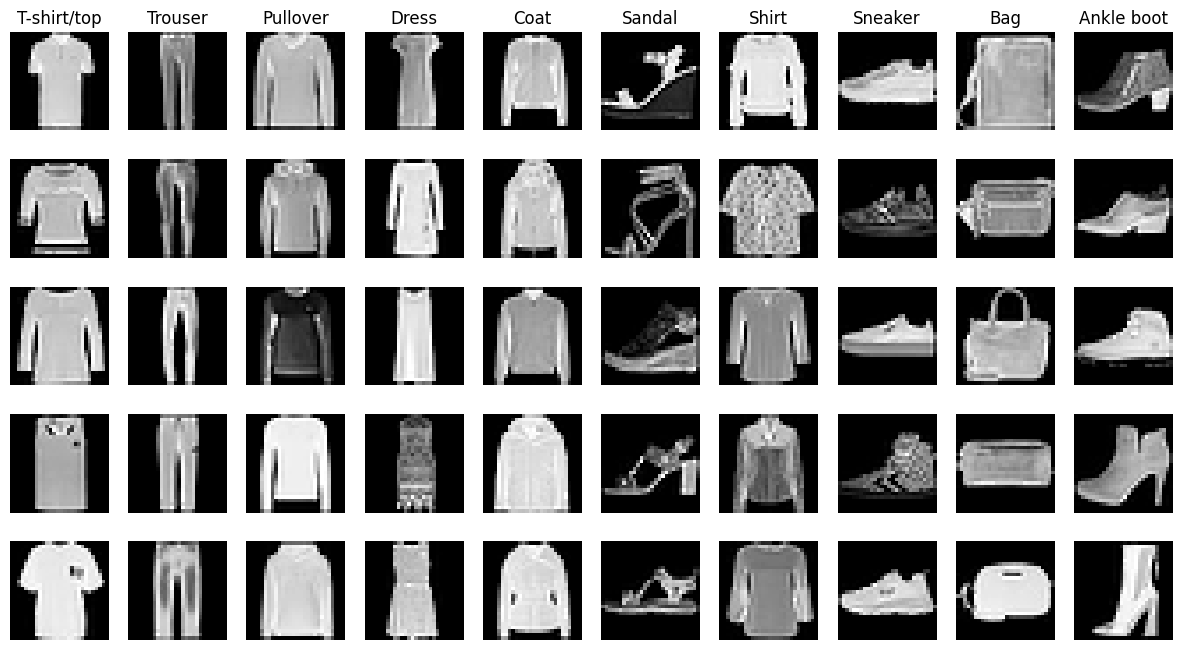

In [33]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.

classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
num_classes = len(classes)
samples_per_class = 5
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(train_labels == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(train_images_float[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)

### Create the Keras model
The input data is in the range of [0, 255]. We need to rescale the input data to the range of [0, 1] before feeding it to the model because the model should train on normalized and standardized data. We can do this by dividing the input data by 255. Thus, we ensure that all features are in the same range. We create a simple Keras model with one convolutional layers and a dense layer. The model is compiled with the Adam optimizer and the categorical cross-entropy loss function.

In [34]:
# Define the model architecture (version 1 - simple model)
fp_model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28)),
  tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
  tf.keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10)
])

In [35]:
# Compile the model
fp_model.compile(optimizer='adam',
                # the loss function is the sparse categorical cross-entropy
                # loss. It is used when there are two or more label classes. 
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

In [36]:
# View the model summary
fp_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 12)        120       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 12)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 2028)              0         
                                                                 
 dense_1 (Dense)             (None, 10)                20290     
                                                                 
Total params: 20,410
Trainable params: 20,410
Non-trainable params: 0
__________________________________________________

In [37]:
# Train the model (this will take a while)
# The early stopping (es) callback will stop the training when the validation loss stops improving
es = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
history = fp_model.fit(
    train_images,
    train_labels,
    epochs=10,
    validation_data=(test_images, test_labels),
    callbacks=[es]
)

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4963 - accuracy: 0.8284 - val_loss: 0.3898 - val_accuracy: 0.8639
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3563 - accuracy: 0.8762 - val_loss: 0.3529 - val_accuracy: 0.8743
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3205 - accuracy: 0.8875 - val_loss: 0.3425 - val_accuracy: 0.8791
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2965 - accuracy: 0.8958 - val_loss: 0.3124 - val_accuracy: 0.8900
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2804 - accuracy: 0.9014 - val_loss: 0.3022 - val_accuracy: 0.8938
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2682 - accuracy: 0.9052 - val_loss: 0.2994 - val_accuracy: 0.8926
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2565 - accuracy: 0.9091 - val_loss: 0.3030 - val_accuracy:

In [38]:
# save the model so we can use it later
# without having to retrain it

# check if 'model' directory exists
if not os.path.exists('models'):
    os.makedirs('models')
fp_model.save('models/fmnist_model_f32.h5')

In [39]:
# Evaluate the model on the test set
fp_test_loss, fp_test_acc = fp_model.evaluate(test_images,  test_labels, verbose=2)
print('Test accuracy:', fp_test_acc)
print('Test loss:', fp_test_loss)

313/313 - 0s - loss: 0.2935 - accuracy: 0.8964 - 216ms/epoch - 692us/step
Test accuracy: 0.896399974822998
Test loss: 0.29346585273742676


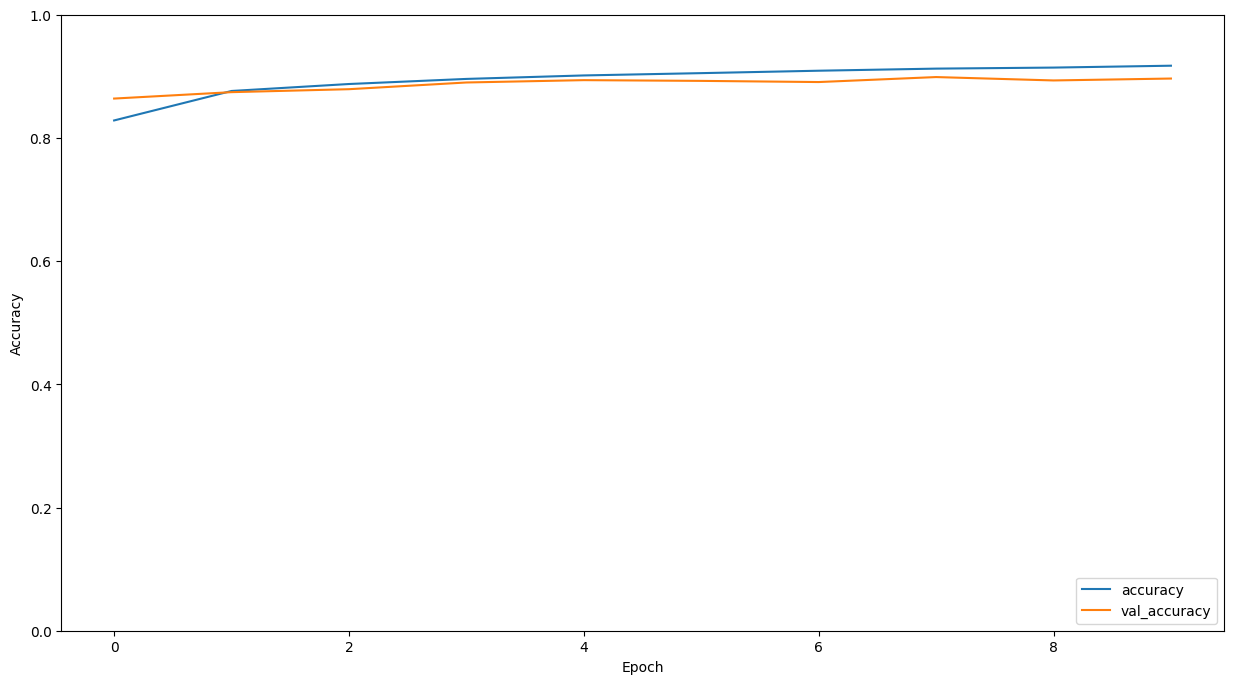

In [40]:
# Plot the training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

# Evaluate the accuracy via a confusion matrix
We can evaluate the accuracy of the model by plotting a confusion matrix. The confusion matrix shows the ratio of correct and incorrect predictions for each class.

In [41]:
# plot the confusion matrix for the quantized model
from sklearn.metrics import confusion_matrix
import itertools

"""
function: plot_confusion_matrix
    - input: cm, classes, normalize, title, cmap
    - output: none
    - description: plots the confusion matrix
"""

def plot_confusion_matrix(cm, classes,
                            normalize=False,
                            title='Confusion matrix',
                            cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

313/313 [==============================] - 0s 636us/step
Confusion matrix, without normalization
[[846   0  23  25   2   1  95   0   8   0]
 [  4 978   2  12   3   0   1   0   0   0]
 [ 16   0 895   9  29   0  50   0   0   1]
 [ 13   8  12 914  20   0  31   0   2   0]
 [  1   0 123  34 785   0  56   0   1   0]
 [  0   0   0   0   0 970   0  16   0  14]
 [123   1 103  31  52   0 681   0   9   0]
 [  0   0   0   0   0  11   0 934   1  54]
 [  4   2   2   4   0   1   5   3 979   0]
 [  0   0   0   0   0   4   0  13   1 982]]


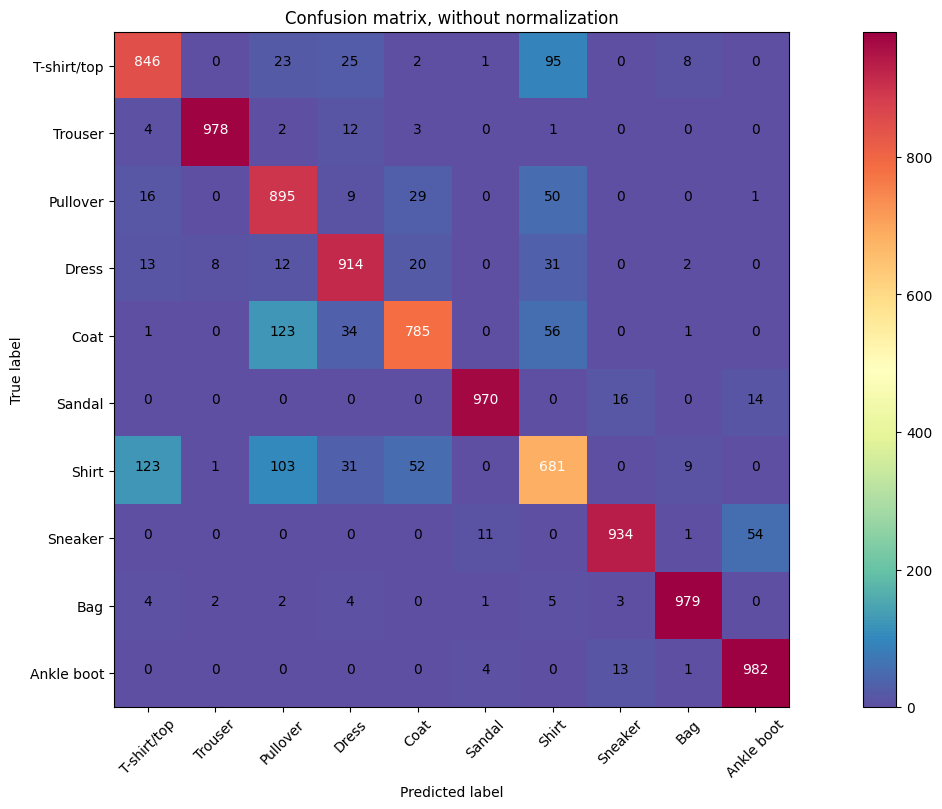

In [42]:
cm = confusion_matrix(test_labels, np.argmax(fp_model.predict(test_images), axis=-1))
plot_confusion_matrix(cm, classes, title='Confusion matrix, without normalization', cmap=plt.cm.Spectral.reversed())

# Convert the keras model to a tflite model
We can convert the keras model to a tflite model by using the `tf.lite.TFLiteConverter.from_keras_model_file()` function. After converting the model, we can save it to a file. Furthermore, we compare the size of the keras model and the tflite model. The difference is due to the fact that we have a lot of metadata in the keras model which is not present in the tflite model, such as the model architecture, optimizer, loss function, etc. This is also why you cannot call the `model.summary()` function on the tflite model.

In [43]:
# Convert the model to TFLite without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(fp_model)
fp_tflite_model = converter.convert()

# Save the model to disk
open("models/fmnist_model_f32.tflite", "wb").write(fp_tflite_model)

# Show the model size for the non-quantized HDF5 model
fp_h5_in_kb = os.path.getsize('models/fmnist_model_f32.h5') / 1024
print("HDF5 Model size without quantization: %d KB" % fp_h5_in_kb)

# Show the model size for the non-quantized TFLite model
fp_tflite_in_kb = os.path.getsize('models/fmnist_model_f32.tflite') / 1024
print("TFLite Model size without quantization: %d KB" % fp_tflite_in_kb)

# Determine the reduction in model size
print("\nReduction in file size by a factor of %f" % (fp_h5_in_kb / fp_tflite_in_kb))

INFO:tensorflow:Assets written to: /tmp/tmpztwqa0gu/assets


INFO:tensorflow:Assets written to: /tmp/tmpztwqa0gu/assets


HDF5 Model size without quantization: 266 KB
TFLite Model size without quantization: 82 KB

Reduction in file size by a factor of 3.210516


# Task 2

### Quantize with dynamic range optimization
We convert the Keras model to an float32 tflite model with dynamic range optimization. Dynamic range quantization is a technique that uses the full range of the data type to represent the weights and activations. This is done by calculating the range of the weights and activations and then scaling them to the full range of the data type. This is done by using the `tf.lite.Optimize.DEFAULT` flag which enables quantization of all fixed parameters. However, this only quantizes static parameters such as weights and biases. The input and output tensors are not quantized. 

In [44]:
# Convert the model to TFLite with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(fp_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
dynR_quant_tflite_model = converter.convert()

# Save the model to disk
open("models/fmnist_model_quant8_dynR.tflite", "wb").write(dynR_quant_tflite_model)


print("Model was saved at location: %s" % os.path.abspath('models/fmnist_model_quant8_dynR.tflite'))

INFO:tensorflow:Assets written to: /tmp/tmp4ruwg94q/assets


INFO:tensorflow:Assets written to: /tmp/tmp4ruwg94q/assets


Model was saved at location: /media/master/wext/msc_studies/second_semester/microcontrollers/project/code/lab7/models/fmnist_model_quant8_dynR.tflite


In [45]:
interpreter = tf.lite.Interpreter(model_content=dynR_quant_tflite_model)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.float32'>
output:  <class 'numpy.float32'>


### Quantize the model to 8-bit integer precision
We can also quantize the model to **full** 8-bit integer precision. This will reduce the model size and improve the inference speed. To quantize the variable data (such as model input/output and intermediates between layers), you need to provide a `RepresentativeDataset`. This is a generator function that provides a set of input data that's large enough to represent typical values. It allows the converter to estimate a dynamic range for all the variable data. (The dataset does not need to be unique compared to the training or evaluation dataset.) To support multiple inputs, each representative data point is a list and elements in the list are fed to the model according to their indices.

In [46]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(fp_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant_int8 = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpqh5ql27a/assets


INFO:tensorflow:Assets written to: /tmp/tmpqh5ql27a/assets
/home/master/.conda/envs/sc/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


In [47]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant_int8)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


In [48]:
# Save the quantized model to disk
open("models/fmnist_full_quant.tflite", "wb").write(tflite_model_quant_int8)

print("Model was saved at location: %s" % os.path.abspath('models/fmnist_full_quant.tflite'))

Model was saved at location: /media/master/wext/msc_studies/second_semester/microcontrollers/project/code/lab7/models/fmnist_full_quant.tflite


In [49]:
# Show the model size for the 8-bit quantized TFLite model
tflite_quant_in_kb = os.path.getsize('models/fmnist_full_quant.tflite') / 1024
print("TFLite Model size with 8-bit quantization: %d KB" % tflite_quant_in_kb)

print("TFLite Model size without quantization: %d KB" % fp_tflite_in_kb)

# Determine the reduction in model size
print("\nReduction in model size by a factor of %f" % (fp_tflite_in_kb / tflite_quant_in_kb))

TFLite Model size with 8-bit quantization: 24 KB
TFLite Model size without quantization: 82 KB

Reduction in model size by a factor of 3.438756


### Performance evaluation of TF Lite models
Before deploying the model to the MCU we would like to get an idea about how good it will perform on the actual hardware. For a first estimate we can do it in software. In order to evaluate the performance of our TF Lite models we have to define a few helper functions. The `run_tflite_model` function performs the inference on the TF Lite model. The inference is initiated by the `invoke` method of the interpreter. The `set_input_tensor` method sets the input tensor. The `get_output_tensor` method returns the output tensor. The `evaluate_model` function evaluates the performance of the model by running inference on the whole test dataset and returning the accuracy.

In [50]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices):
  global test_images

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(test_image_indices),), dtype=int)
  for i, test_image_index in enumerate(test_image_indices):
    test_image = test_images[test_image_index]
    test_label = test_labels[test_image_index]

    if (test_image_index % 1000 == 0):
      print("Evaluated on %d images." % test_image_index)

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    predictions[i] = output.argmax()

  return predictions


# Helper function to evaluate a TFLite model on all images
def evaluate_model(tflite_file, model_type):
  global test_images
  global test_labels

  test_image_indices = range(test_images.shape[0])
  predictions = run_tflite_model(tflite_file, test_image_indices)

  accuracy = (np.sum(test_labels== predictions) * 100) / len(test_images)

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(test_images)))

In [51]:
# this might take a few minutes (~ 1- 2 minutes)
# if it takes longer than that, I suggest to 
# restart the runtime and try again
# if the issue still persists, restart your computer
tflite_model_quant_int8_file = pathlib.Path('models/fmnist_full_quant.tflite')
tflite_model_quant_int8_model_type = "Full Post-Quantized INT8"

evaluate_model(tflite_model_quant_int8_file, tflite_model_quant_int8_model_type)
print("Full-precision model accuracy is %.4f%% (Number of test samples=%d)" % (fp_test_acc * 100, len(test_images)))

Evaluated on 0 images.
Evaluated on 1000 images.
Evaluated on 2000 images.
Evaluated on 3000 images.
Evaluated on 4000 images.
Evaluated on 5000 images.
Evaluated on 6000 images.
Evaluated on 7000 images.
Evaluated on 8000 images.
Evaluated on 9000 images.
Full Post-Quantized INT8 model accuracy is 89.5200% (Number of test samples=10000)
Full-precision model accuracy is 89.6400% (Number of test samples=10000)


Evaluated on 0 images.
Evaluated on 1000 images.
Evaluated on 2000 images.
Evaluated on 3000 images.
Evaluated on 4000 images.
Evaluated on 5000 images.
Evaluated on 6000 images.
Evaluated on 7000 images.
Evaluated on 8000 images.
Evaluated on 9000 images.
Confusion matrix, without normalization
[[854   0  24  23   2   1  89   0   7   0]
 [  4 978   2  12   3   0   1   0   0   0]
 [ 17   0 901   7  28   0  47   0   0   0]
 [ 16   8  14 914  18   0  29   0   1   0]
 [  1   0 128  37 779   0  54   0   1   0]
 [  0   0   0   0   0 969   0  17   0  14]
 [134   2 118  30  55   0 654   0   7   0]
 [  0   0   0   0   0  11   0 944   1  44]
 [  4   2   3   4   1   1   3   3 979   0]
 [  1   0   0   0   0   4   0  15   0 980]]


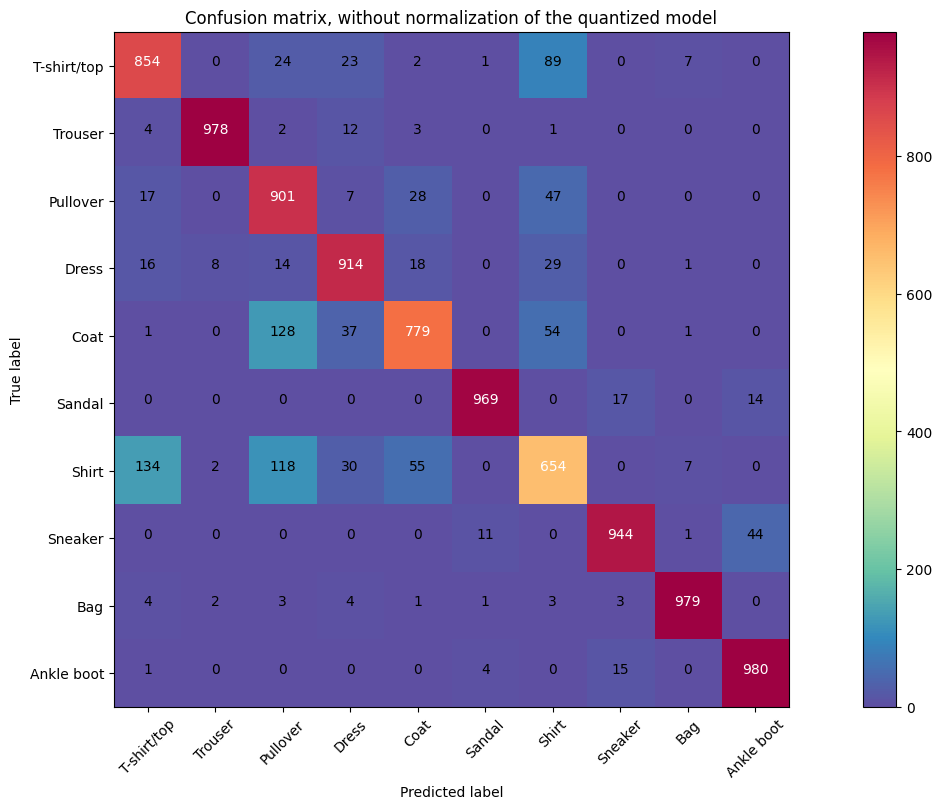

In [52]:
# we plot also the confusion matrix of the quantized model
tflite_model_quant_int8_pred = run_tflite_model(tflite_model_quant_int8_file, range(test_images.shape[0]))
cm = confusion_matrix(test_labels, tflite_model_quant_int8_pred);
plot_confusion_matrix(cm, classes, title='Confusion matrix, without normalization of the quantized model', cmap=plt.cm.Spectral.reversed())

In [53]:
# compute the accuracy of the quantized model
from sklearn.metrics import accuracy_score
full_int8_accuracy = accuracy_score(test_labels, tflite_model_quant_int8_pred)
print("Full-precision model accuracy is %.4f%% (Number of test samples=%d)" % (fp_test_acc * 100, len(test_images)))
print("Quantized model accuracy is %.4f%% (Number of test samples=%d)" % (full_int8_accuracy * 100, len(test_images)))

Full-precision model accuracy is 89.6400% (Number of test samples=10000)
Quantized model accuracy is 89.5200% (Number of test samples=10000)


### Writing the model to a C header file for use on the MCU
We need to store the model parameters in a C header file so that we can run inference on the microcontroller with new input data (i.e.) from the testset. 

In [54]:
# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

    c_str = ''

    # Create header guard
    c_str += '#ifndef ' + var_name.upper() + '_H\n'
    c_str += '#define ' + var_name.upper() + '_H\n\n'

    # Add array length at top of file
    c_str += '\nstatic const unsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

    # Declare C variable
    c_str += 'static const unsigned char ' + var_name + '[] = {'
    hex_array = []
    for i, val in enumerate(hex_data) :

        # Construct string from hex
        hex_str = format(val, '#04x')

        # Add formatting so each line stays within 80 characters
        if (i + 1) < len(hex_data):
            hex_str += ','
        if (i + 1) % 12 == 0:
            hex_str += '\n '
        hex_array.append(hex_str)

    # Add closing brace
    c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

    # Close out header guard
    c_str += '#endif //' + var_name.upper() + '_H'

    return c_str

In [55]:
c_model_name = 'q8fmnist'
# check if dir 'cfiles' exists, if not create it
if not os.path.exists('cfiles'):
    os.makedirs('cfiles')
# Write TFLite model to a C source (or header) file
with open('cfiles/' + c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model_quant_int8, c_model_name))

### Saving test data used for inference on the MCU
Additionally, we will save some samples from the test set which we will send via UART to the microcontroller. The microcontroller will then perform inference on these samples and send the results back to the host computer via a Python script that we prepared for you. 

Test image data location:  /media/master/wext/msc_studies/second_semester/microcontrollers/project/code/lab7/x_test_fmnist.npy
Test labels location:  /media/master/wext/msc_studies/second_semester/microcontrollers/project/code/lab7/y_test_fmnist.npy


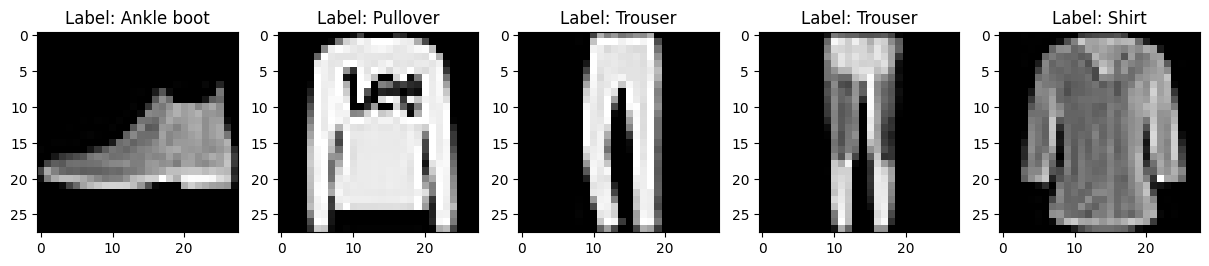

In [56]:
# save the test data as numpy arrays
np.save('x_test_fmnist.npy', test_images_float.astype(np.uint8))
np.save('y_test_fmnist.npy', test_labels.astype(np.uint8))
# plot the first 5 images in the test set with their labels
# map class labels to names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(test_images_float.astype(np.uint8)[i], cmap='gray')
    plt.title('Label: %s' % class_names[test_labels[i]])

# print the location of the files
print('Test image data location: ', os.path.abspath('x_test_fmnist.npy'))
print('Test labels location: ', os.path.abspath('y_test_fmnist.npy'))

# Task 3

### Quantization-aware training
In this exercise, the dataset and model are very simple and the accuracy drop in more advanced applications might drop tremendously. A way to mitigate this is to train the model with quantization in mind. This is called quantization-aware training. In this exercise, we will train a model with quantization-aware training and then convert it to a TF Lite model. In order to generate a QAT model, we can use TF's `tfmot.quantization.keras.quantize_model` API. Afterward, we proceed in the same manner as before.

In [57]:
!pip install -q tensorflow-model-optimization

In [58]:
import tensorflow_model_optimization as tfmot

# Convert the model to a quantization aware model
quant_aware_model = tfmot.quantization.keras.quantize_model(fp_model)

# `quantize_model` requires a recompile.
quant_aware_model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

quant_aware_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer_1 (QuantizeL  (None, 28, 28)           3         
 ayer)                                                           
                                                                 
 quant_reshape_1 (QuantizeWr  (None, 28, 28, 1)        1         
 apperV2)                                                        
                                                                 
 quant_conv2d_1 (QuantizeWra  (None, 26, 26, 12)       147       
 pperV2)                                                         
                                                                 
 quant_max_pooling2d_1 (Quan  (None, 13, 13, 12)       1         
 tizeWrapperV2)                                                  
                                                                 
 quant_flatten_1 (QuantizeWr  (None, 2028)            

In [59]:
# Train and evaluate the quantization aware model
quant_aware_model.fit(
                  train_images,
                  train_labels,
                  epochs=10,
                  validation_data=(test_images, test_labels),
                  callbacks=[es]
              )

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2259 - accuracy: 0.9198 - val_loss: 0.2948 - val_accuracy: 0.8981
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2192 - accuracy: 0.9218 - val_loss: 0.2828 - val_accuracy: 0.8997
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2126 - accuracy: 0.9236 - val_loss: 0.2927 - val_accuracy: 0.8954
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2070 - accuracy: 0.9261 - val_loss: 0.2838 - val_accuracy: 0.8978
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2030 - accuracy: 0.9273 - val_loss: 0.2861 - val_accuracy: 0.9025
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1994 - accuracy: 0.9285 - val_loss: 0.2831 - val_accuracy: 0.9008
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1957 - accuracy: 0.9299 - val_loss: 0.2957 - val_accuracy:

We see that the accuracy of the QAT model is higher than the accuracy of the model that was quantized after training. The effect of quantization-aware training is more pronounced in more complex models.

In [60]:
# evaluate the model on the test set
quant_loss, quant_acc = quant_aware_model.evaluate(test_images, test_labels, verbose=0)
print('Quantization aware training loss: ', quant_loss)
print('Quantization aware training accuracy: ', quant_acc)
print('Full-precision training accuracy: ', fp_test_acc)

Quantization aware training loss:  0.28284183144569397
Quantization aware training accuracy:  0.8996999859809875
Full-precision training accuracy:  0.896399974822998


In [61]:
# convert the QAT model to a fully quantized model using TFLite

def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant_int8_qat = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpjdxuffqm/assets


INFO:tensorflow:Assets written to: /tmp/tmpjdxuffqm/assets
/home/master/.conda/envs/sc/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


In [62]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant_int8_qat)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)
# Save the quantized model to disk
open("models/fmnist_qat_int8.tflite", "wb").write(tflite_model_quant_int8_qat)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


25072

In [63]:
c_model_name = 'qat8fmnist'
# Write TFLite model to a C source (or header) file
with open('cfiles/' + c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model_quant_int8_qat, c_model_name))

In [64]:
# this might take a few minutes (~ 1- 2 minutes)
# if it takes longer than that, I suggest to 
# restart the runtime and try again
# if the issue still persists, restart your computer
tflite_model_quant_int8_qat_file = pathlib.Path('models/fmnist_qat_int8.tflite')
tflite_model_quant_int8_qat_type = "Full QAT INT8"

evaluate_model(tflite_model_quant_int8_qat_file, tflite_model_quant_int8_qat_type)
print("Full-precision model accuracy is %.4f%% (Number of test samples=%d)" % (fp_test_acc * 100, len(test_images)))

Evaluated on 0 images.
Evaluated on 1000 images.
Evaluated on 2000 images.
Evaluated on 3000 images.
Evaluated on 4000 images.
Evaluated on 5000 images.
Evaluated on 6000 images.
Evaluated on 7000 images.
Evaluated on 8000 images.
Evaluated on 9000 images.
Full QAT INT8 model accuracy is 89.9700% (Number of test samples=10000)
Full-precision model accuracy is 89.6400% (Number of test samples=10000)


Evaluated on 0 images.
Evaluated on 1000 images.
Evaluated on 2000 images.
Evaluated on 3000 images.
Evaluated on 4000 images.
Evaluated on 5000 images.
Evaluated on 6000 images.
Evaluated on 7000 images.
Evaluated on 8000 images.
Evaluated on 9000 images.
Confusion matrix, without normalization
[[886   0  15  17   5   3  68   0   6   0]
 [  3 981   2   9   3   0   2   0   0   0]
 [ 22   1 857   7  45   0  68   0   0   0]
 [ 21   9  13 899  23   0  34   0   1   0]
 [  2   0  91  28 822   0  57   0   0   0]
 [  0   0   0   0   0 984   0  11   0   5]
 [144   1  70  25  67   0 684   0   9   0]
 [  0   0   0   0   0  20   0 955   1  24]
 [  6   2   2   1   4   6   8   3 968   0]
 [  0   0   0   0   0   9   1  29   0 961]]


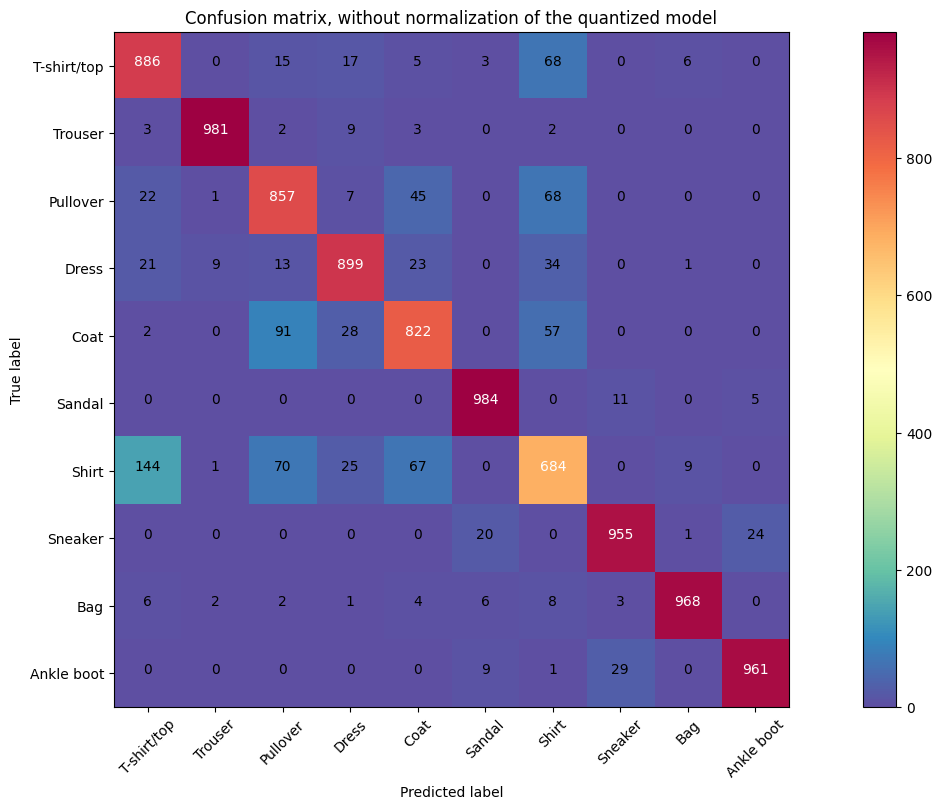

In [65]:
# evaluate the model on the test set
tflite_model_quant_int8_qat_file = "models/fmnist_qat_int8.tflite"
tflite_model_quant_int8_qat_model_type = "Quantized aware training model"
tflite_model_quant_int8_qat_pred = run_tflite_model(tflite_model_quant_int8_qat_file, range(test_images.shape[0]))
cm = confusion_matrix(test_labels, tflite_model_quant_int8_qat_pred);
plot_confusion_matrix(cm, classes, title='Confusion matrix, without normalization of the quantized model', cmap=plt.cm.Spectral.reversed())


In [66]:
# compute the accuracy of the model
full_qat_int8_accuracy = accuracy_score(test_labels, tflite_model_quant_int8_qat_pred)
print('Full QAT INT8 accuracy is %.4f%% (Number of test samples=%d)' % (full_qat_int8_accuracy * 100, len(test_images)))
print('Full-precision model accuracy is %.4f%% (Number of test samples=%d)' % (fp_test_acc * 100, len(test_images)))

Full QAT INT8 accuracy is 89.9700% (Number of test samples=10000)
Full-precision model accuracy is 89.6400% (Number of test samples=10000)


In [67]:
raise SystemExit("Stop right there!")

SystemExit: Stop right there!

/home/master/.conda/envs/sc/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# Task 4

  ### Quantization-aware training with pruning
  In order to further optimize the model, we can combine quantization-aware training with pruning. Pruning denotes the removal of static parameters. It helps to mitigate negative side effects of machine learning models such as overfitting, model complexity, and model size. For pruning, we can define a schedule, but also the type of pruning, i.e. structured or unstructured. In TensorFlow, we can use the `tfmot.sparsity.keras.prune_low_magnitude` API to prune a model.  <br/>
  
  * **Structured pruning** Involves removing entire groups of parameters from the model, i.e. weights are systematically zeroed out at the beginning of the training process. For example, in a CNN, we might remove entire filters from a layer, which would remove all the weights associated with that filter. The shape of the model is preserved. <br/>
  
  * **Unstructured pruning** Here, we are removing individual parameters from the model, without any regard for their position in the model. We try to find and remove the less salient connection in the model wherever they are. For example, we might simply remove the smallest weights from the model, regardless of where they are located. The shape of the model is not preserved. This type of pruning is sometimes referred to as _channel pruning_. By default, unstructured pruning is used except if the `block_size` parameter is specified in the `pruning_params` of the `PruneLowMagnitude` class. <br/>

  The schedule can be either constant or dynamic. <br/>
  * **Constant pruning schedule** The pruning rate is constant throughout the training process. This means we eliminate the same number of parameters at each step. <br/>
  
  * **Dynamic pruning schedule** The pruning rate might change during training, i.e. the sparsity changes. <br/>

### 1. Structured pruning with constant sparsity

In [ ]:
# Strucutred pruning with constant sparsity
pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.5, begin_step=2000, frequency=100),
        'block_size': (1, 1),
}

# Create a pruning model
pruned_model = tfmot.sparsity.keras.prune_low_magnitude(fp_model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
pruned_model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

pruned_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_reshape  (None, 28, 28, 1)        1         
 _1 (PruneLowMagnitude)                                          
                                                                 
 prune_low_magnitude_conv2d_  (None, 26, 26, 12)       230       
 1 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_max_poo  (None, 13, 13, 12)       1         
 ling2d_1 (PruneLowMagnitude                                     
 )                                                               
                                                                 
 prune_low_magnitude_flatten  (None, 2028)             1         
 _1 (PruneLowMagnitude)                                          
                                                      

<color style="color:red"> **Important:** </color> If you get an error like `train_function -> train_function`, simply run the cell again. Furthermore, you might need the `tfmot.sparsity.keras.UpdatePruningStep` in the training loop.

In [ ]:
# Train and evaluate the pruned model
# if you get an error like train_function -> train_function
# just run the cell again
pruned_model.fit(
                    train_images,
                    train_labels,
                    epochs=10,
                    validation_data=(test_images, test_labels),
                    callbacks=[es]
)

Epoch 1/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2245 - accuracy: 0.9213 - val_loss: 0.2912 - val_accuracy: 0.8996
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2422 - accuracy: 0.9141 - val_loss: 0.2930 - val_accuracy: 0.8958
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2257 - accuracy: 0.9206 - val_loss: 0.2934 - val_accuracy: 0.8954
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2200 - accuracy: 0.9226 - val_loss: 0.2882 - val_accuracy: 0.8978
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2163 - accuracy: 0.9230 - val_loss: 0.2912 - val_accuracy: 0.8983
Epoch 6/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2128 - accuracy: 0.9254 - val_loss: 0.2933 - val_accuracy: 0.8987
Epoch 7/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2098 - accuracy: 0.9260 - val_loss: 0.2903 - val_accuracy:

In [ ]:
# evaluate the model on the test set
pruned_loss, pruned_acc = pruned_model.evaluate(test_images, test_labels, verbose=0)
print('Pruned model loss: ', pruned_loss)
print('Pruned model accuracy: ', pruned_acc)
print('Full-precision model accuracy: ', fp_test_acc)

Pruned model loss:  0.2881898581981659
Pruned model accuracy:  0.8978000283241272
Full-precision model accuracy:  0.8928999900817871


### Conversion to TF Lite
For pruned models, we need the `tfmot.sparsity.keras.strip_pruning` API to convert the model to a TF Lite model. It applies a standard compression algorithm (e.g. via gzip) are necessary to see the compression benefits of pruning. `strip_pruning` is necessary since it removes every `tf.Variable` that pruning only needs during training, which would otherwise add to model size during inference. Applying a standard compression algorithm is necessary since the serialized weight matrices are the same size as they were before pruning. However, pruning makes most of the weights zeros, which is added redundancy that algorithms can utilize to further compress the model.

In [ ]:
pruned_model_for_export = tfmot.sparsity.keras.strip_pruning(pruned_model)

pruned_keras_file = 'models/pruned_model.h5'
tf.keras.models.save_model(pruned_model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', os.path.abspath(pruned_keras_file))

Saved pruned Keras model to: /media/master/wext/msc_studies/second_semester/microcontrollers/exercices/7/Exercise7/jupyter/models/pruned_model.h5


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(pruned_model_for_export)
pruned_tflite_model = converter.convert()

pruned_tflite_file = 'models/pruned_model.tflite'

with open(pruned_tflite_file, 'wb') as f:
    f.write(pruned_tflite_model)

print('Saved pruned TFLite model to:', os.path.abspath(pruned_tflite_file))

INFO:tensorflow:Assets written to: /tmp/tmpqcrvj0m6/assets


INFO:tensorflow:Assets written to: /tmp/tmpqcrvj0m6/assets


Saved pruned TFLite model to: /media/master/wext/msc_studies/second_semester/microcontrollers/exercices/7/Exercise7/jupyter/models/pruned_model.tflite


2023-04-03 20:47:54.430423: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-04-03 20:47:54.430500: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-04-03 20:47:54.436970: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-04-03 20:47:54.466193: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpqcrvj0m6
2023-04-03 20:47:54.491483: I tensorflow/cc/saved_model/loader.cc:305] SavedModel load for tags { serve }; Status: success: OK. Took 60707 microseconds.


In [ ]:
c_model_name = 'prunedfmnist'
# Write TFLite model to a C source (or header) file
with open('cfiles/' + c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(pruned_tflite_model, c_model_name))

In [ ]:
# Define a helper function to actually compress the models via gzip and measure the zipped size.
import tempfile

def get_gzipped_model_size(file):
    # It returns the size of the gzipped model in bytes.
    import os
    import zipfile
    
    _, zipped_file = tempfile.mkstemp('.zip')
    with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(file)
    
    return os.path.getsize(zipped_file)

<color style="color:red"> **Important:** </color> For newer versions of Python the `tensorflow.lite.experimental.Analyzer.analyze(model_content=tflite_model)` function can be used, which is more accurate than our custom `get_gzipped_model_size` function. However, it is still experimental and might not work on your system.

In [ ]:
# compare the size of the pruned model and the full-precision model
print('Size of the pruned model: ', get_gzipped_model_size(pruned_tflite_file))
print('Size of the full-precision model: ', get_gzipped_model_size('models/fmnist_model_f32.tflite'))
print("The achieved compression ratio is %.2fx" % (get_gzipped_model_size('models/fmnist_model_f32.tflite') / get_gzipped_model_size(pruned_tflite_file)))

Size of the pruned model:  48059
Size of the full-precision model:  77663
The achieved compression ratio is 1.62x


In [ ]:
# evaluate the model on the test set
pruned_tflite_file = "models/pruned_model.tflite"
pruned_tflite_model_type = "Pruned model"
evaluate_model(pruned_tflite_file, pruned_tflite_model_type)
print("Full-precision model accuracy is %.4f%% (Number of test samples=%d)" % (fp_test_acc * 100, len(test_images)))

Evaluated on 0 images.
Evaluated on 1000 images.
Evaluated on 2000 images.
Evaluated on 3000 images.
Evaluated on 4000 images.
Evaluated on 5000 images.
Evaluated on 6000 images.
Evaluated on 7000 images.
Evaluated on 8000 images.
Evaluated on 9000 images.
Pruned model model accuracy is 89.7800% (Number of test samples=10000)
Full-precision model accuracy is 89.2900% (Number of test samples=10000)


Evaluated on 0 images.
Evaluated on 1000 images.
Evaluated on 2000 images.
Evaluated on 3000 images.
Evaluated on 4000 images.
Evaluated on 5000 images.
Evaluated on 6000 images.
Evaluated on 7000 images.
Evaluated on 8000 images.
Evaluated on 9000 images.
Confusion matrix, without normalization
[[863   0  12  31   6   1  76   0  11   0]
 [  4 974   1  16   2   0   2   0   1   0]
 [ 19   1 828  11  70   0  69   0   2   0]
 [ 18   6  13 919  20   0  23   0   1   0]
 [  2   0  54  36 863   0  44   0   1   0]
 [  0   0   0   1   0 973   0  18   0   8]
 [137   1  64  36  84   0 666   0  12   0]
 [  0   0   0   0   0  14   0 954   1  31]
 [  4   2   4   2   3   1   4   3 977   0]
 [  0   0   0   0   0   9   1  29   0 961]]


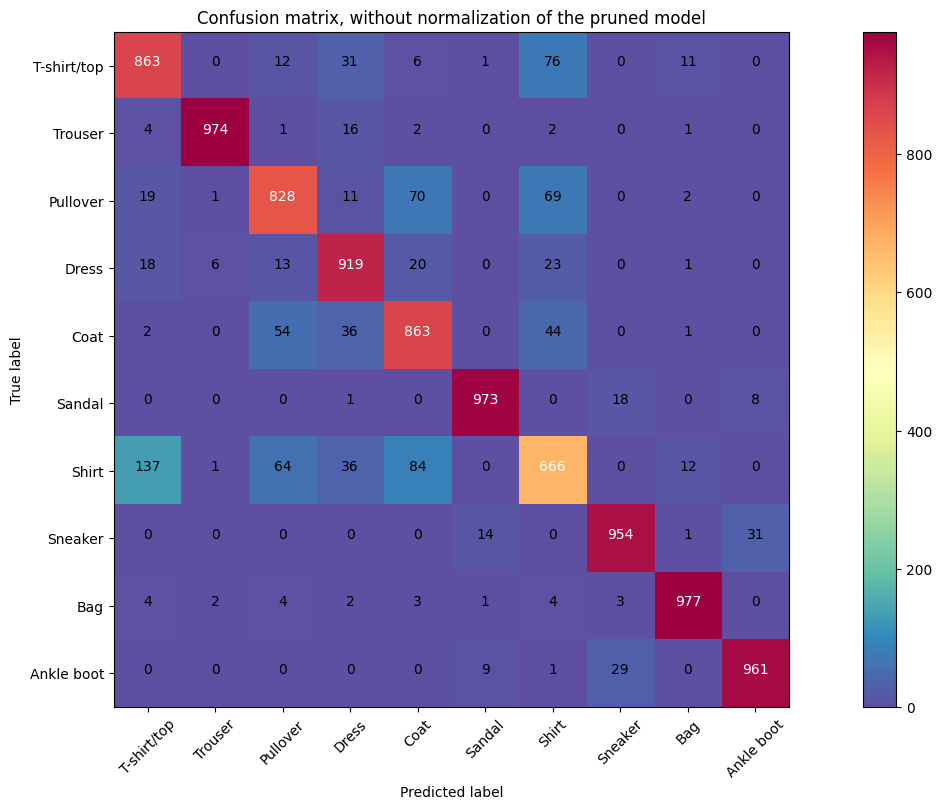

In [ ]:
# evaluate the model on the test set
pruned_tflite_file = "models/pruned_model.tflite"
pruned_tflite_model_type = "Pruned model"
pruned_tflite_pred = run_tflite_model(pruned_tflite_file, range(test_images.shape[0]))
cm = confusion_matrix(test_labels, pruned_tflite_pred);
plot_confusion_matrix(cm, classes, title='Confusion matrix, without normalization of the pruned model', cmap=plt.cm.Spectral.reversed())

In [ ]:
# compute the accuracy of the model
pruned_accuracy = accuracy_score(test_labels, pruned_tflite_pred)
print('Pruned model accuracy is %.4f%% (Number of test samples=%d)' % (pruned_accuracy * 100, len(test_images)))
print('Full-precision model accuracy is %.4f%% (Number of test samples=%d)' % (fp_test_acc * 100, len(test_images)))

Pruned model accuracy is 89.7800% (Number of test samples=10000)
Full-precision model accuracy is 89.2900% (Number of test samples=10000)


### 2. Unstructured pruning with constant sparsity

In [ ]:
# Unstrucutred pruning with constant sparsity
pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.5, begin_step=2000, frequency=100),
}

# Create a pruning model
pruned_model_unstructured = tfmot.sparsity.keras.prune_low_magnitude(fp_model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
pruned_model_unstructured.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

pruned_model_unstructured.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_reshape  (None, 28, 28, 1)        1         
 _1 (PruneLowMagnitude)                                          
                                                                 
 prune_low_magnitude_conv2d_  (None, 26, 26, 12)       230       
 1 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_max_poo  (None, 13, 13, 12)       1         
 ling2d_1 (PruneLowMagnitude                                     
 )                                                               
                                                                 
 prune_low_magnitude_flatten  (None, 2028)             1         
 _1 (PruneLowMagnitude)                                          
                                                      

In [ ]:
# Train and evaluate the pruned model
pruned_model_unstructured.fit(
                    train_images,
                    train_labels,
                    epochs=10,
                    validation_data=(test_images, test_labels),
                    callbacks=[es]
)

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2247 - accuracy: 0.9197 - val_loss: 0.3018 - val_accuracy: 0.8971
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2139 - accuracy: 0.9239 - val_loss: 0.2906 - val_accuracy: 0.8979
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2100 - accuracy: 0.9259 - val_loss: 0.2940 - val_accuracy: 0.8981
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2072 - accuracy: 0.9271 - val_loss: 0.2885 - val_accuracy: 0.8998
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2053 - accuracy: 0.9271 - val_loss: 0.2933 - val_accuracy: 0.8987
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2031 - accuracy: 0.9284 - val_loss: 0.2950 - val_accuracy: 0.8983
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2011 - accuracy: 0.9294 - val_loss: 0.2921 - val_accuracy:

In [ ]:
# evaluate the model on the test set
pruned_loss_unstructured, pruned_acc_unstructured = pruned_model_unstructured.evaluate(test_images, test_labels, verbose=0)
print('Pruned model loss: ', pruned_loss_unstructured)
print('Pruned model accuracy: ', pruned_acc_unstructured)
print('Full-precision model accuracy: ', fp_test_acc)

Pruned model loss:  0.28845492005348206
Pruned model accuracy:  0.8998000025749207
Full-precision model accuracy:  0.8928999900817871


### Conversion to TF Lite

In [ ]:
# Conversion to TF Lite
pruned_model_unstructured_for_export = tfmot.sparsity.keras.strip_pruning(pruned_model_unstructured)

pruned_keras_file_unstructured = 'models/pruned_model_unstructured.h5'
tf.keras.models.save_model(pruned_model_unstructured_for_export, pruned_keras_file_unstructured, include_optimizer=False)
print('Saved pruned Keras model to:', os.path.abspath(pruned_keras_file_unstructured))

Saved pruned Keras model to: /media/master/wext/msc_studies/second_semester/microcontrollers/exercices/7/Exercise7/jupyter/models/pruned_model_unstructured.h5


In [ ]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(pruned_model_unstructured_for_export)
pruned_tflite_model_unstructured = converter.convert()

# Save the model
pruned_tflite_file_unstructured = 'models/pruned_model_unstructured.tflite'

with open(pruned_tflite_file_unstructured, 'wb') as f:
    f.write(pruned_tflite_model_unstructured)

print('Saved pruned TFLite model to:', os.path.abspath(pruned_tflite_file_unstructured))

INFO:tensorflow:Assets written to: /tmp/tmpu7rxk0r2/assets


INFO:tensorflow:Assets written to: /tmp/tmpu7rxk0r2/assets


Saved pruned TFLite model to: /media/master/wext/msc_studies/second_semester/microcontrollers/exercices/7/Exercise7/jupyter/models/pruned_model_unstructured.tflite


2023-04-03 20:52:58.683558: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-04-03 20:52:58.683577: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-04-03 20:52:58.687340: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-04-03 20:52:58.696696: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpu7rxk0r2
2023-04-03 20:52:58.700830: I tensorflow/cc/saved_model/loader.cc:305] SavedModel load for tags { serve }; Status: success: OK. Took 17151 microseconds.


In [ ]:
c_model_name = 'unstr_prunedfmnist'
# Write TFLite model to a C source (or header) file
with open('cfiles/' + c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(pruned_tflite_model_unstructured, c_model_name))

In [ ]:
# compare the size of the pruned model and the full-precision model
print('Size of the unstructured pruned model: ', get_gzipped_model_size(pruned_tflite_file_unstructured))
print('Size of the structured pruned model: ', get_gzipped_model_size(pruned_tflite_file))
print('Size of the full-precision model: ', get_gzipped_model_size('models/fmnist_model_f32.tflite'))
print("The achieved compression ratio is %.2fx" % (get_gzipped_model_size('models/fmnist_model_f32.tflite') / get_gzipped_model_size(pruned_tflite_file_unstructured)))

Size of the unstructured pruned model:  48355
Size of the structured pruned model:  48059
Size of the full-precision model:  77663
The achieved compression ratio is 1.61x


In [ ]:
# evaluate the model on the test set
pruned_tflite_file_unstructured = "models/pruned_model_unstructured.tflite"
pruned_tflite_model_type_unstructured = "Pruned model unstructured"
evaluate_model(pruned_tflite_file_unstructured, pruned_tflite_model_type_unstructured)
print("Full-precision model accuracy is %.4f%% (Number of test samples=%d)" % (fp_test_acc * 100, len(test_images)))

Evaluated on 0 images.
Evaluated on 1000 images.
Evaluated on 2000 images.
Evaluated on 3000 images.
Evaluated on 4000 images.
Evaluated on 5000 images.
Evaluated on 6000 images.
Evaluated on 7000 images.
Evaluated on 8000 images.
Evaluated on 9000 images.
Pruned model unstructured model accuracy is 89.9800% (Number of test samples=10000)
Full-precision model accuracy is 89.2900% (Number of test samples=10000)


Evaluated on 0 images.
Evaluated on 1000 images.
Evaluated on 2000 images.
Evaluated on 3000 images.
Evaluated on 4000 images.
Evaluated on 5000 images.
Evaluated on 6000 images.
Evaluated on 7000 images.
Evaluated on 8000 images.
Evaluated on 9000 images.
Confusion matrix, without normalization
[[868   0  13  29   7   1  71   0  11   0]
 [  4 976   1  14   2   0   2   0   1   0]
 [ 19   1 834  11  69   0  64   0   2   0]
 [ 21   7  14 914  21   0  22   0   1   0]
 [  2   0  52  35 868   0  42   0   1   0]
 [  0   0   0   1   0 971   0  19   0   9]
 [133   1  62  37  80   0 676   0  11   0]
 [  0   0   0   0   0  11   0 957   1  31]
 [  5   3   4   2   3   1   4   3 975   0]
 [  0   0   0   0   0   9   1  31   0 959]]


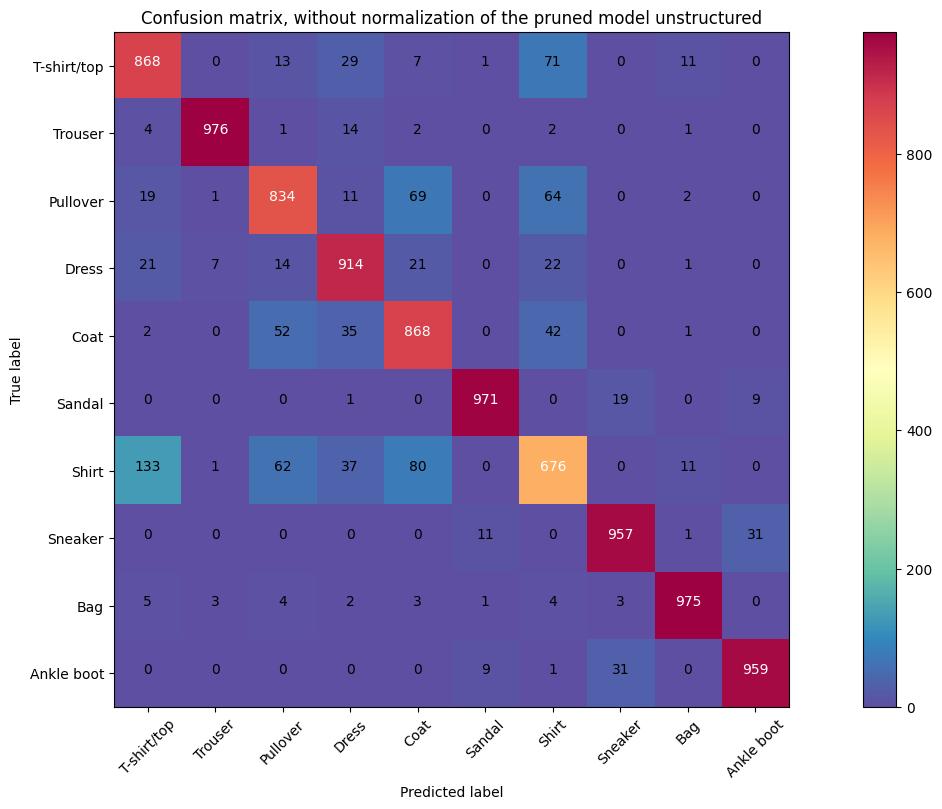

In [ ]:
# evaluate the model on the test set
pruned_tflite_file_unstructured = "models/pruned_model_unstructured.tflite"
pruned_tflite_model_type_unstructured = "Pruned model unstructured"
pruned_tflite_pred_unstructured = run_tflite_model(pruned_tflite_file_unstructured, range(test_images.shape[0]))
cm = confusion_matrix(test_labels, pruned_tflite_pred_unstructured);
plot_confusion_matrix(cm, classes, title='Confusion matrix, without normalization of the pruned model unstructured', cmap=plt.cm.Spectral.reversed())


In [ ]:
# compute the accuracy of the model
pruned_accuracy_unstructured = accuracy_score(test_labels, pruned_tflite_pred_unstructured)
print('Unstructured pruned model accuracy is %.4f%% (Number of test samples=%d)' % (pruned_accuracy_unstructured * 100, len(test_images)))
print('Structured pruned model accuracy is %.4f%% (Number of test samples=%d)' % (pruned_accuracy * 100, len(test_images)))
print('Full-precision model accuracy is %.4f%% (Number of test samples=%d)' % (fp_test_acc * 100, len(test_images)))

Unstructured pruned model accuracy is 89.9800% (Number of test samples=10000)
Structured pruned model accuracy is 89.7800% (Number of test samples=10000)
Full-precision model accuracy is 89.2900% (Number of test samples=10000)


### 3. Unstructured pruning with dynamic sparsity

In [ ]:
# Unstructured pruning with dynamic sparsity
pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                                    final_sparsity=0.80,
                                                                    begin_step=2000,
                                                                    end_step=4000,
                                                                    frequency=100)

}

# Create a pruning model
pruned_model_unstructured_dynamic = tfmot.sparsity.keras.prune_low_magnitude(fp_model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
pruned_model_unstructured_dynamic.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

pruned_model_unstructured_dynamic.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_reshape  (None, 28, 28, 1)        1         
 _1 (PruneLowMagnitude)                                          
                                                                 
 prune_low_magnitude_conv2d_  (None, 26, 26, 12)       230       
 1 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_max_poo  (None, 13, 13, 12)       1         
 ling2d_1 (PruneLowMagnitude                                     
 )                                                               
                                                                 
 prune_low_magnitude_flatten  (None, 2028)             1         
 _1 (PruneLowMagnitude)                                          
                                                      

In [ ]:
# Train and evaluate the pruned model
# we increase the patience to 5 to avoid early stopping
# too early since the unsctructured pruning is more aggressive
# and requires more epochs to converge
# es = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
pruned_model_unstructured_dynamic.fit(
                    train_images,
                    train_labels,
                    epochs=10,
                    validation_data=(test_images, test_labels),
                    callbacks=[es]
)

Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2153 - accuracy: 0.9232 - val_loss: 0.3053 - val_accuracy: 0.8971
Epoch 2/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2930 - accuracy: 0.8944 - val_loss: 0.3597 - val_accuracy: 0.8705
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2927 - accuracy: 0.8964 - val_loss: 0.3443 - val_accuracy: 0.8778
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2795 - accuracy: 0.9006 - val_loss: 0.3363 - val_accuracy: 0.8828
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2727 - accuracy: 0.9028 - val_loss: 0.3342 - val_accuracy: 0.8863
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2680 - accuracy: 0.9041 - val_loss: 0.3324 - val_accuracy: 0.8878


In [ ]:
# evaluate the model on the test set
pruned_loss_unstructured_dynamic, pruned_acc_unstructured_dynamic = pruned_model_unstructured_dynamic.evaluate(test_images, test_labels, verbose=0)
print('Dynamically unstructured pruned model loss: ', pruned_loss_unstructured_dynamic)
print('Dynamically unstructured pruned model accuracy: ', pruned_acc_unstructured_dynamic)
print('Full-precision model accuracy: ', fp_test_acc)

Dynamically unstructured pruned model loss:  0.30527231097221375
Dynamically unstructured pruned model accuracy:  0.8970999717712402
Full-precision model accuracy:  0.8928999900817871


In [ ]:
# Conversion to Keras Lite
pruned_model_unstructured_dynamic_for_export = tfmot.sparsity.keras.strip_pruning(pruned_model_unstructured_dynamic)

pruned_keras_file_unstructured_dynamic = 'models/pruned_model_unstructured_dynamic.h5'
tf.keras.models.save_model(pruned_model_unstructured_dynamic_for_export, pruned_keras_file_unstructured_dynamic, include_optimizer=False)
print('Saved pruned Keras model to:', os.path.abspath(pruned_keras_file_unstructured_dynamic))  

Saved pruned Keras model to: /media/master/wext/msc_studies/second_semester/microcontrollers/exercices/7/Exercise7/jupyter/models/pruned_model_unstructured_dynamic.h5


In [ ]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(pruned_model_unstructured_dynamic_for_export)
pruned_tflite_model_unstructured_dynamic = converter.convert()

# Save the model
pruned_tflite_file_unstructured_dynamic = 'models/pruned_model_unstructured_dynamic.tflite'

with open(pruned_tflite_file_unstructured_dynamic, 'wb') as f:
    f.write(pruned_tflite_model_unstructured_dynamic)

print('Saved pruned TFLite model to:', os.path.abspath(pruned_tflite_file_unstructured_dynamic))

INFO:tensorflow:Assets written to: /tmp/tmpks1oh_f1/assets


INFO:tensorflow:Assets written to: /tmp/tmpks1oh_f1/assets


Saved pruned TFLite model to: /media/master/wext/msc_studies/second_semester/microcontrollers/exercices/7/Exercise7/jupyter/models/pruned_model_unstructured_dynamic.tflite


2023-04-03 20:53:43.350723: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-04-03 20:53:43.350750: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-04-03 20:53:43.354231: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-04-03 20:53:43.365469: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpks1oh_f1
2023-04-03 20:53:43.370129: I tensorflow/cc/saved_model/loader.cc:305] SavedModel load for tags { serve }; Status: success: OK. Took 19252 microseconds.


In [ ]:
# write TFLite model to a C source (or header) file
c_model_name = 'unstr_dyn_prunedfmnist'

with open('cfiles/' + c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(pruned_tflite_model_unstructured_dynamic, c_model_name))

In [ ]:
# compare the size of the pruned model and the full-precision model
print('Size of the unstructured dynamically pruned model: ', get_gzipped_model_size(pruned_tflite_file_unstructured_dynamic))
print('Size of the full-precision model: ', get_gzipped_model_size('models/fmnist_model_f32.tflite'))
print("The achieved compression ratio is %.2fx" % (get_gzipped_model_size('models/fmnist_model_f32.tflite') / get_gzipped_model_size(pruned_tflite_file_unstructured_dynamic)))

Size of the unstructured dynamically pruned model:  76808
Size of the full-precision model:  77663
The achieved compression ratio is 1.01x


In [ ]:
# evaluate the model on the test set
pruned_tflite_file_unstructured_dynamic = "models/pruned_model_unstructured_dynamic.tflite"
pruned_tflite_model_type_unstructured_dynamic = "Pruned model unstructured dynamic"
evaluate_model(pruned_tflite_file_unstructured_dynamic, pruned_tflite_model_type_unstructured_dynamic)
print("Full-precision model accuracy is %.4f%% (Number of test samples=%d)" % (fp_test_acc * 100, len(test_images)))

Evaluated on 0 images.
Evaluated on 1000 images.
Evaluated on 2000 images.
Evaluated on 3000 images.
Evaluated on 4000 images.
Evaluated on 5000 images.
Evaluated on 6000 images.
Evaluated on 7000 images.
Evaluated on 8000 images.
Evaluated on 9000 images.
Pruned model unstructured dynamic model accuracy is 89.7100% (Number of test samples=10000)
Full-precision model accuracy is 89.2900% (Number of test samples=10000)


Evaluated on 0 images.
Evaluated on 1000 images.
Evaluated on 2000 images.
Evaluated on 3000 images.
Evaluated on 4000 images.
Evaluated on 5000 images.
Evaluated on 6000 images.
Evaluated on 7000 images.
Evaluated on 8000 images.
Evaluated on 9000 images.
Confusion matrix, without normalization
[[873   0  13  26  10   3  60   0  15   0]
 [  1 975   1  14   6   0   2   0   1   0]
 [ 21   1 811   9 106   0  47   0   5   0]
 [ 20   7  11 901  36   0  20   0   5   0]
 [  2   0  34  24 919   0  18   0   3   0]
 [  0   0   0   0   0 987   0   7   2   4]
 [142   1  65  35 128   0 615   0  14   0]
 [  0   0   0   0   0  25   0 948   2  25]
 [  4   2   2   2   3   3   3   2 979   0]
 [  0   0   0   0   0  10   1  26   0 963]]


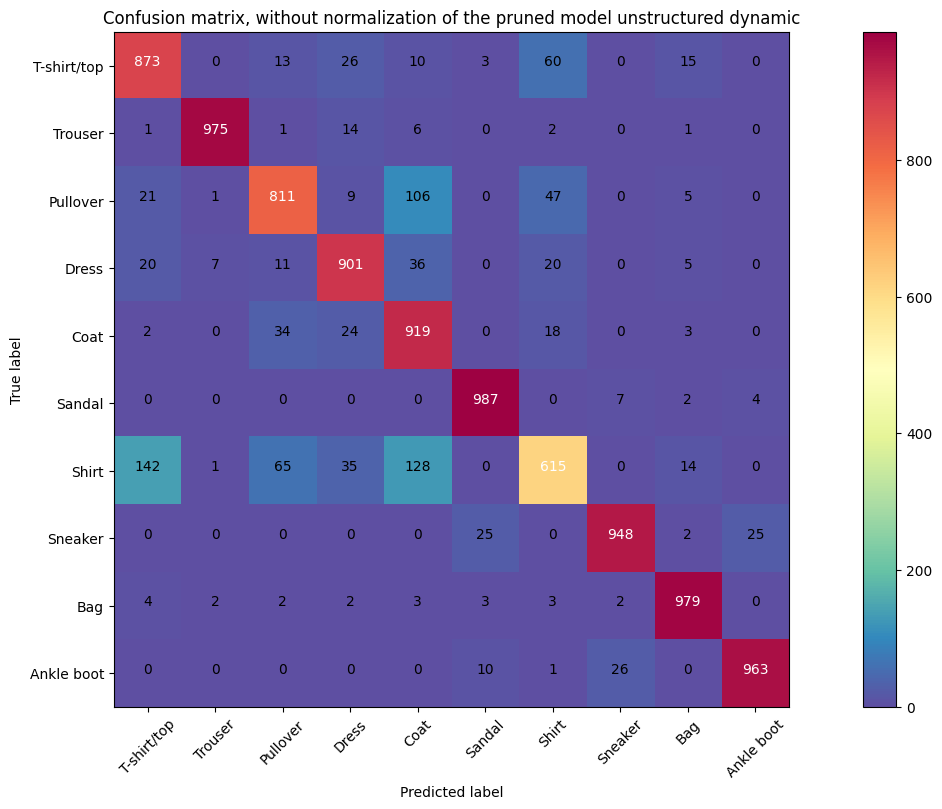

In [ ]:
# evaluate the model on the test set
pruned_tflite_file_unstructured_dynamic = "models/pruned_model_unstructured_dynamic.tflite"
pruned_tflite_model_type_unstructured_dynamic = "Pruned model unstructured dynamic"
pruned_tflite_pred_unstructured_dynamic = run_tflite_model(pruned_tflite_file_unstructured_dynamic, range(test_images.shape[0]))
cm = confusion_matrix(test_labels, pruned_tflite_pred_unstructured_dynamic);
plot_confusion_matrix(cm, classes, title='Confusion matrix, without normalization of the pruned model unstructured dynamic', cmap=plt.cm.Spectral.reversed())

In [ ]:
# compute the accuracy of the model
pruned_accuracy_unstructured_dynamic = accuracy_score(test_labels, pruned_tflite_pred_unstructured_dynamic)
print('Pruned model accuracy is %.4f%% (Number of test samples=%d)' % (pruned_accuracy_unstructured_dynamic * 100, len(test_images)))
print('Full-precision model accuracy is %.4f%% (Number of test samples=%d)' % (fp_test_acc * 100, len(test_images)))

Pruned model accuracy is 89.7100% (Number of test samples=10000)
Full-precision model accuracy is 89.2900% (Number of test samples=10000)


### Conclusion
We see that we sacrifice some accuracy for the sake of model size and inference speed. However, we can alleviate this effect by combining pruning with quantization-aware training. In the next exercise, you will see how to do this.

# Task 5

### Quantization-aware training with pruning
Finally, we want to combine quantization-aware training with pruning. Thus, we find a good trade-off between accuracy, model size, and inference speed. For this exercise we will use the less aggressive pruning schedule and the unstructured pruning method. The `quantize_annotate_model` function annotates the model with quantization information and the `quantize_apply` function applies the quantization to the model. The `Default8BitPrunePreserveQuantizeScheme` preserves the sparsity of the QAT model.

In [ ]:
# PQAT
quant_aware_annotate_model = tfmot.quantization.keras.quantize_annotate_model(
              pruned_model_unstructured_for_export)

pruned_qat_model = tfmot.quantization.keras.quantize_apply(quant_aware_annotate_model,
                   tfmot.experimental.combine.Default8BitPrunePreserveQuantizeScheme())

pruned_qat_model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

pruned_qat_model.summary()

In [ ]:
# train the model
pruned_qat_model.fit(
                    train_images,
                    train_labels,
                    epochs=10,
                    validation_data=(test_images, test_labels),
                    callbacks=[es]
)

In [ ]:
# evaluate the model on the test set
pruned_qat_loss, pruned_qat_acc = pruned_qat_model.evaluate(test_images, test_labels, verbose=0)
print('Pruned QAT model loss: ', pruned_qat_loss)
print('Pruned QAT model accuracy: ', pruned_qat_acc)
print('Full-precision model accuracy: ', fp_test_acc)

In [ ]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(pruned_qat_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
pruned_qat_tflite_model = converter.convert()

# Save the model
pruned_qat_tflite_file = 'models/pruned_qat_model.tflite'

with open(pruned_qat_tflite_file, 'wb') as f:
    f.write(pruned_qat_tflite_model)

print('Saved pruned QAT TFLite model to:', os.path.abspath(pruned_qat_tflite_file))

# write TFLite model to a C source (or header) file
c_model_name = 'pruned_qat_fmnist'

with open('cfiles/' + c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(pruned_qat_tflite_model, c_model_name))

# compare the size of the pruned model and the full-precision model
print('Size of the pruned QAT model: ', get_gzipped_model_size(pruned_qat_tflite_file))
print('Size of th QAT model: ', get_gzipped_model_size( 'models/fmnist_qat_int8.tflite'))
print('Size of the full-precision model: ', get_gzipped_model_size('models/fmnist_model_f32.tflite'))
print("The achieved compression ratio is %.2fx" % (get_gzipped_model_size('models/fmnist_model_f32.tflite') / get_gzipped_model_size(pruned_qat_tflite_file)))

In [ ]:
# evaluate the model on the test set
pruned_qat_tflite_file = "models/pruned_qat_model.tflite"
pruned_qat_tflite_model_type = "Pruned QAT model"
evaluate_model(pruned_qat_tflite_file, pruned_qat_tflite_model_type)
print("Full-precision model accuracy is %.4f%% (Number of test samples=%d)" % (fp_test_acc * 100, len(test_images)))

In [ ]:
# evaluate the model on the test set
pruned_qat_tflite_file = "models/pruned_qat_model.tflite"
pruned_qat_tflite_model_type = "Pruned QAT model"
pruned_qat_tflite_pred = run_tflite_model(pruned_qat_tflite_file, range(test_images.shape[0]))
cm = confusion_matrix(test_labels, pruned_qat_tflite_pred);
plot_confusion_matrix(cm, classes, title='Confusion matrix, without normalization of the pruned QAT model', cmap=plt.cm.Spectral.reversed())

In [ ]:
# compute the accuracy of the model
pruned_qat_accuracy = accuracy_score(test_labels, pruned_qat_tflite_pred)
print('Pruned QAT model accuracy is %.4f%% (Number of test samples=%d)' % (pruned_qat_accuracy * 100, len(test_images)))
print('Full-precision model accuracy is %.4f%% (Number of test samples=%d)' % (fp_test_acc * 100, len(test_images)))

# Result Summary

In [ ]:
from prettytable import PrettyTable
# create a table with the results
model_types = ['full precision', 'PTQ', 'sPruned constant', 'uPruned constant', 'uPruned dynamic', 'PQAT']
model_accuracies = [fp_test_acc, full_int8_accuracy, pruned_accuracy, pruned_accuracy_unstructured, pruned_accuracy_unstructured_dynamic, pruned_qat_accuracy]
# cut precision to 4 decimal places
model_accuracies = [round(x, 4) for x in model_accuracies]
model_sizes = [get_gzipped_model_size('models/fmnist_model_f32.tflite'), get_gzipped_model_size('models/fmnist_full_quant.tflite'), get_gzipped_model_size('models/pruned_model.tflite'), get_gzipped_model_size('models/pruned_model_unstructured.tflite'), get_gzipped_model_size('models/pruned_model_unstructured_dynamic.tflite'), get_gzipped_model_size('models/pruned_qat_model.tflite')]
# divide by 1000 to get the size in KB
model_sizes = [round(x / 1000, 2) for x in model_sizes]

table = PrettyTable()
table.field_names = ["Model type", "Accuracy", "Size (KB)"]
for i in range(len(model_types)):
    table.add_row([model_types[i], model_accuracies[i], model_sizes[i]])
print(table)

# plot model on x axis and accuracy on y axis
# and make size of the points proportional to the size of the model
plt.figure(figsize=(15, 8))
sns.scatterplot(x=model_types, y=model_accuracies, size=model_sizes, sizes=(100, 1000), hue=model_types)
# do not show the legend
plt.legend([], [], frameon=False)
# get only legend for model type
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
# only keep first 6 elements of dict
by_label = {k: by_label[k] for k in list(by_label)[:6]}
plt.legend(by_label.values(), by_label.keys(), title='Model type', loc='lower right')
# annotate the points with the size of the model
for i in range(len(model_types)):
    plt.annotate(str(model_sizes[i]) + 'kB', (model_types[i], model_accuracies[i] + 0.0001))


plt.title('Accuracy vs model type')
plt.xlabel('Model type')
plt.ylabel('Accuracy')
plt.show()